## 1. Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image


## 2. Import Model and Images

### 2.1 Import Model

In [3]:
model = load_model('../Models/segmentation_model.h5')

### 2.2 Import Images

In [4]:
# Load and preprocess the image
img_path = 'Resources/images/img_0001.png'
#img_path = 'Resources/test_Images/test_image_001.png'  # Replace with the actual path to your image
#img_path = 'Resources/test_Images/test_image_001.png'
img = load_img(img_path, target_size=(384,384))  # Replace height and width with your model's input size
img_array_org = img_to_array(img)
img_array = np.expand_dims(img_array_org, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if required by your model

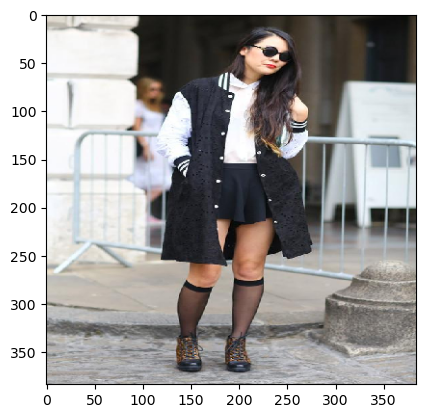

In [5]:
# Display image
plt.imshow(img)

## 3. Make Predictions

In [6]:
# Predict image mask
predicted_mask = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


In [7]:
# Get image mask shape
predicted_mask.shape

(1, 384, 384, 59)

In [8]:
# Use the squeeze fuction to change the image mask shape
predicted_mask = np.squeeze(predicted_mask, axis=0)
predicted_mask.shape

(384, 384, 59)

In [9]:
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask.shape

(384, 384)

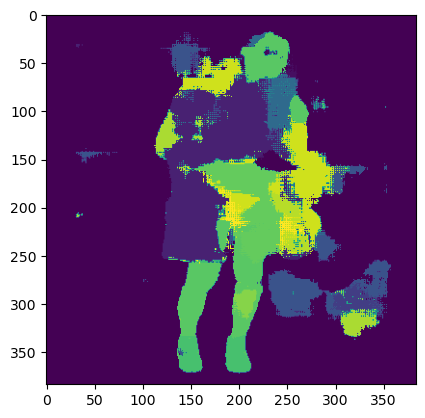

In [10]:
# Display the predicted mask
plt.imshow(predicted_mask, cmap='viridis')  # Use 'viridis' or another colormap for multi-class
plt.show()

In [11]:
# Precicted classes
np.unique(predicted_mask)

array([ 0,  1,  2,  4,  5, 10, 13, 14, 19, 26, 31, 35, 38, 39, 41, 42, 45,
       48, 49, 51, 55])

## 4. Get Bounding Boxes of classes

In [12]:
# Create a function to get the bounding boxes
def get_class_bounding_boxes(mask, num_classes):
    """
    Find bounding boxes for each class in the segmentation mask.
    
    Args:
    mask: np.array, shape (height, width), contains class labels for each pixel.
    num_classes: int, number of classes.
    
    Returns:
    bounding_boxes: dict, where keys are class indices and values are bounding boxes (x_min, y_min, x_max, y_max).
    """
    bounding_boxes = {}
    
    for class_idx in range(num_classes):
        # Find all pixels belonging to the current class
        class_mask = (mask == class_idx).astype(np.uint8)

        # Find contours for the class mask
        contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Find the bounding box around the largest contour
            x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x + w), max(y_max, y + h)
            
            bounding_boxes[class_idx] = (x_min, y_min, x_max, y_max)

    return bounding_boxes

In [13]:
num_classes = predicted_mask.max() + 1  
bounding_boxes = get_class_bounding_boxes(predicted_mask, num_classes)

# bounding_boxes will now contain the bounding box for each class
for class_idx, box in bounding_boxes.items():
    print(f"Class {class_idx}: Bounding Box {box}")

Class 0: Bounding Box (0, 0, 384, 384)
Class 1: Bounding Box (138, 32, 269, 353)
Class 2: Bounding Box (138, 37, 261, 354)
Class 4: Bounding Box (220, 146, 258, 206)
Class 5: Bounding Box (31, 31, 278, 258)
Class 10: Bounding Box (295, 278, 347, 314)
Class 13: Bounding Box (63, 143, 303, 291)
Class 14: Bounding Box (31, 19, 358, 355)
Class 19: Bounding Box (203, 19, 261, 121)
Class 26: Bounding Box (132, 68, 291, 249)
Class 31: Bounding Box (182, 255, 187, 257)
Class 35: Bounding Box (155, 255, 186, 258)
Class 38: Bounding Box (156, 255, 181, 258)
Class 39: Bounding Box (136, 287, 222, 373)
Class 41: Bounding Box (136, 18, 273, 358)
Class 42: Bounding Box (136, 150, 250, 259)
Class 45: Bounding Box (139, 278, 219, 318)
Class 48: Bounding Box (31, 86, 353, 338)
Class 49: Bounding Box (142, 106, 275, 291)
Class 51: Bounding Box (124, 44, 315, 257)
Class 55: Bounding Box (136, 155, 272, 259)


### 5. Get Labels from Classes

In [14]:
# Import labels from csv file
labels = pd.read_csv('Resources/labels/labels.csv')
# Drop unamed column
labels.drop('Unnamed: 0', axis=1, inplace=True)
# Display labels
labels.head()


,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,belt,other
4,blazer,upper


In [15]:
labels['category'].unique()

array(['other', 'upper', 'shoes', 'head', 'lower'], dtype=object)

In [16]:
# Get label names from bounding_boxes keys
image_labels = labels.iloc[list(bounding_boxes.keys())].reset_index(drop=True)
image_labels

,label_list,category
0,NaN,other
1,accessories,other
2,bag,other
3,blazer,upper
4,blouse,upper
5,cape,upper
6,coat,upper
7,dress,upper
8,hair,other
9,jumper,upper


### 6. Create images from the bounding boxes

In [17]:
images=[]
pixels = []
# Loop through bounding boxes, crop images and save them to disk
for class_idx, box in bounding_boxes.items():
    class_name = labels.iloc[class_idx]['label_list']
    temp_img = img.crop(box)
    images.append(temp_img)
    pixels.append(temp_img.size[0]*temp_img.size[1])

In [18]:
image_labels['pixels'] = pixels
image_labels = image_labels.sort_values(by='pixels', ascending=False)
image_labels

,label_list,category,pixels
0,NaN,other,147456
7,dress,upper,109872
17,sweater,upper,81144
4,blouse,upper,56069
14,skin,other,46580
1,accessories,other,42051
19,t-shirt,upper,40683
2,bag,other,38991
6,coat,upper,35520
9,jumper,upper,28779


In [19]:
def get_middle_index(df):
    if len(df)%2 == 0:
        return int(len(df)/2)-1
    else:
        return int((len(df) - 1)/2)

In [20]:
head = image_labels[(image_labels['category'] == 'head') & (image_labels['pixels'] > 3000)]
if len(head) >= 1:
    head = head.iloc[get_middle_index(head)]
    images[head.name].save(f'Output/images/head.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/head.png')

In [21]:
upper = image_labels[(image_labels['category'] == 'upper') & (image_labels['pixels'] > 3000)]
if len(upper) >= 1:
    upper = upper.iloc[get_middle_index(upper)]
    images[upper.name].save(f'Output/images/upper.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/upper.png')

In [22]:
lower = image_labels[(image_labels['category'] == 'lower') & (image_labels['pixels'] > 3000)]
if len(lower) >= 1:
    lower = lower.iloc[get_middle_index(lower)]
    images[lower.name].save(f'Output/images/lower.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/lower.png')

In [23]:
shoes = image_labels[(image_labels['category'] == 'shoes') & (image_labels['pixels'] > 3000)]
if len(shoes) >= 1:
    shoes = shoes.iloc[get_middle_index(shoes)]
    images[shoes.name].save(f'Output/images/shoes.png')
else:
    Image.new('RGB', (10, 10)).save(f'Output/images/shoes.png')

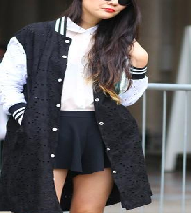

In [24]:
images[upper.name]

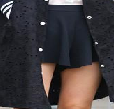

In [25]:
images[lower.name]

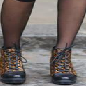

In [26]:
images[shoes.name]

In [27]:
import os
import base64
import requests
from dotenv import load_dotenv

# OpenAI API Key
api_key = os.getenv("OPENAI_API_KEY")

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "Output/images/upper.png"

# Getting the base64 string
base64_image = encode_image(image_path)

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": "gpt-4o-mini",
  "messages": [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Upper Clothing color, type and length. Message should only include these two details"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)


In [28]:
data = response.json()
data

{'error': {'message': 'Incorrect API key provided: None. You can find your API key at https://platform.openai.com/account/api-keys.',
  'type': 'invalid_request_error',
  'param': None,
  'code': 'invalid_api_key'}}

In [29]:
data = response.json()
item = data['choices'][0]['message']['content'].replace('\n',', ')
item

KeyError: 'choices'

In [30]:
import serpapi
def get_recommendations(item):
    # Load environment variables and API key
    load_dotenv()   
    # Create query for search
    query = f"Shop for Women's {item}"
    # Search google shopping
    search = GoogleSearch({
        "q": query, 
        "api_key": os.getenv("GOOGLE_SEARCH_API_KEY"),
        "tbm": "shop",  # shop
        "tbs": "p_ord:rv", # last 24h
        "num": 10
        })
    # Convert results into a dataframe
    print(search.get_dict())
    recommendations = pd.DataFrame(search.get_dict()['shopping_results'])

    #recommendations_df.to_csv('search_results/search_results.csv')

    return recommendations

In [31]:
from serpapi.google_search import GoogleSearch 

In [32]:
recommendation = get_recommendations(item)

NameError: name 'item' is not defined

In [33]:
recommendation

NameError: name 'recommendation' is not defined

In [34]:
recommendation['thumbnail'][0]

NameError: name 'recommendation' is not defined

In [35]:
!pip install transformers torch torchvision

from transformers import AutoTokenizer, AutoModel
import torch

# Initialize tokenizer and model for text input processing
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_model = AutoModel.from_pretrained("bert-base-uncased")

# Example function to process event and brand inputs
def process_text_inputs(event, brand):
    inputs = tokenizer(event + " " + brand, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = text_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# Example image feature extraction function (assuming YOLO or similar is already implemented)
def process_image_inputs(image):
    # Your existing image processing code
    image_features = extract_image_features(image)  # Assuming this function exists
    return image_features

# Combine text and image features (simple concatenation in this case)
def combine_features(text_features, image_features):
    combined_features = torch.cat((text_features, image_features), dim=1)
    return combined_features


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/b7/d0/5e8f96d83889e77b478b90e7d8d24a5fc14c5c9350c6b93d071f45f39096/torch-2.4.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/b4/93/611197d5a023a33a48df656287b3e26c6e7db0fa92a9bb2259c0cdb76581/torchvision-0.19.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 MB 49.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled

/Users/jaidevkler/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [36]:
def multimodal_search(event, brand, image):
    # Process the inputs
    text_features = process_text_inputs(event, brand)
    image_features = process_image_inputs(image)

    # Combine features
    combined_features = combine_features(text_features, image_features)

    # Example recommendation logic (this part will vary depending on your dataset and model)
    recommendations = get_recommendations(combined_features)  # Placeholder for your recommendation logic

    return recommendations

# Example placeholder function for recommendation logic
def get_recommendations(features):
    # For simplicity, let's assume you have a nearest neighbor search or some similarity measure
    # In reality, you would compare `features` against a database of clothing items.
    similar_items = ["Item 1", "Item 2", "Item 3"]  # Replace with actual logic
    return similar_items


In [37]:
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

# Event type and brand preference inputs
event_input = widgets.Text(value='', placeholder='Enter event type', description='Event:')
brand_input = widgets.Text(value='', placeholder='Enter brand preference', description='Brand:')
upload_image_button = widgets.FileUpload(description='Upload Image')

# Output area
output_area = widgets.Output()

# Function to handle button click
def on_button_click(b):
    clear_output(wait=True)
    event = event_input.value
    brand = brand_input.value
    type(upload_image_button)
  
    # Assuming only one image is uploaded
    uploaded_image = list(upload_image_button.value)[0]['content']
    
    # Get recommendations
    recommendations = multimodal_search(event, brand, uploaded_image)
    
    # Display recommendations
    with output_area:
        for item in recommendations:
            display(item)  # Replace with actual display logic
        display(Image(uploaded_image))  # Show uploaded image as confirmation

# Search button
search_button = widgets.Button(description="Search")
search_button.on_click(on_button_click)

# Display the UI elements
display(event_input, brand_input, upload_image_button, search_button, output_area)


NameError: name 'extract_image_features' is not defined